# Сегментация клиентов банка

В наличии база клиентов банка с данными по ним.

### Цель проекта: 
- сегментировать клиентов на основе данных о количестве потребляемых продуктов,
- выявить характерные черты сегментов
- сформулировать рекомендации по стимулирующим продажи продуктов мероприятиям

### Структура:


1. [Первичное ознакомление и предобработка данных.](#1)
 - [пропуски](#1.1)
 - [дубликаты](#1.2)
 - [типы данных](#1.3)
 
 
2. [Исследовательский анализ данных:](#2)
 - [построение и анализ распределений](#2.1)
 - [корреляционный анализ](#2.2)
 
 
3. [Сегментация клиентов](#3)
 - [группировка клиентов по количеству продуктов](#3.1)
 - [выявление характерных особенностей групп](#3.2)
 
 
4. [Проверка статистических гипотез:](#4)
 - [проверка статистической гипотезы клиента : «различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним».](#4.1)
 - [формулировка и проверка собственной статистической гипотезы на основе проведенного исследовательского анализа](#4.2)
 
 
5. [Выводы](#5)

## 1. Первичное ознакомление и предобработка данных.<a id=1></a>

#### 1.1 Проверка пропусков<a id=1.1></a>

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
from io import BytesIO
import requests

In [5]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import numpy as np

In [6]:
df = pd.read_csv('bank_dataset.csv')
display(df.head())
df.info()

userid  score       City Gender  Age  Objects    Balance  Products  \
0  15677338    619  Ярославль      Ж   42        2        NaN         1   
1  15690047    608    Рыбинск      Ж   41        1   83807.86         1   
2  15662040    502  Ярославль      Ж   42        8  159660.80         3   
3  15744090    699  Ярославль      Ж   39        1        NaN         2   
4  15780624    850    Рыбинск      Ж   43        2  125510.82         1   

   CreditCard  Loyalty  estimated_salary  Churn  
0           1        1         101348.88      1  
1           0        1         112542.58      0  
2           1        0         113931.57      1  
3           0        0          93826.63      0  
4           1        1          79084.10      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 859.4+ KB


Перед началом работы, для удобства, сменим все символы в названиях колонок на строчные.

In [7]:
df.columns = map(str.lower, df.columns)
df.columns 

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

Наиболее вероятная гипотеза объясняющая отсутствующие значения в колонке balance - то, что не у всех клиентов банка есть свой счет. В противном случае, клиенты без счета, так же могли быть помечены, как клиенты с нулевым остатком. Проверим, есть ли такие?

In [8]:
df.query('balance == 0')

Empty DataFrame
Columns: [userid, score, city, gender, age, objects, balance, products, creditcard, loyalty, estimated_salary, churn]
Index: []

Отсутствие нулевых значений баланса косвенно подтверждает наше предположение. Примем его как верное. Тогда логично заполнить отсутствующие значения нулями. Это будет означать, что остаток средств клиента в нашем банке равен нулю. Дополнительно, нулевое значение будет нести информацию об отсутствии счета.

In [9]:
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 859.4+ KB


#### 1.2 Проверка дубликатов <a id=1.2></a>

Проверим на полные совпадения строк.

In [10]:
df.duplicated().sum()

0

На всякий случай проверим так же, попадал ли один и тот же клиент в выборку но с другими параметрами. Например с другим балансом по счету, в другом возрасте и т.д.

In [11]:
df['userid'].duplicated().sum()

0

Дубликатов не обнаружено.

#### 1.3 Проверка типов данных <a id=1.3></a>

Посмотрим, какие типы данных требуют изменения:
 - 0   userid               (int64)  - не требует
 - 1   score                (int64)  - не требует
 - 2   city                 (object) - не требует
 - 3   gender               (object) - не требует
 - 4   age                  (int64)  - не требует
 - 5   objects              (int64)  - не требует
 - 6   balance              (float64) - нам не требуется такая точность(оптимальнее целые значения)
 - 7   products             (int64)  - не требует
 - 8   creditcard           (int64)  - не требует
 - 9   loyalty              (int64)  - не требует
 - 10  estimated_salary     (float64) - нам не требуется такая точность(оптимальнее целые значения)
 - 11  churn                (int64) - не требует

In [12]:
df['balance'] = df['balance'].astype('int64')
df['estimated_salary'] = df['estimated_salary'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   userid            10000 non-null  int64 
 1   score             10000 non-null  int64 
 2   city              10000 non-null  object
 3   gender            10000 non-null  object
 4   age               10000 non-null  int64 
 5   objects           10000 non-null  int64 
 6   balance           10000 non-null  int64 
 7   products          10000 non-null  int64 
 8   creditcard        10000 non-null  int64 
 9   loyalty           10000 non-null  int64 
 10  estimated_salary  10000 non-null  int64 
 11  churn             10000 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 859.4+ KB


Теперь все типы данных удобны для анализа.

## 2. Исследовательский анализ данных <a id=2></a>


#### 2.1 Построение и анализ распределений <a id=2.1></a>

В общем наборе данных есть категориальные , распределение которых информативнее оценивать в круговых диаграммах. К ним относятся колонки: city, gender, creditcard, loyalty, churn. Из-за маленького диапазона значений, к категориальным условно можно отнести так же колонку products, тем более, что сегментировать мы будем именно по ней. Узнаем как распределены клиенты в этих категориях. 

In [13]:
fig = make_subplots(rows=1, cols=3, 
                specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                
                subplot_titles=['Наличие кредитной <br>карты','Фактор активности <br>клиента','Отток'])


fig.add_trace(go.Pie(labels=['Есть карта','Нет карты'],values = np.array(df['creditcard'].value_counts()), hole=0.7), row=1, col=1)

fig.add_trace(go.Pie(labels=['Активный клиент','Не активный клиент'], values = np.array(df['loyalty'].value_counts()),hole=0.7), row=1, col=2)

fig.add_trace(go.Pie(labels=['Остался','Ушел в отток'],values = np.array(df['churn'].value_counts()), hole=0.7), row=1, col=3)
fig.show()


Посмотрим как распределены клиенты по городам.

In [14]:
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=['Ярославль','Ростов Великий', 'Рыбинск'], 
    values = np.array(df['city'].value_counts()), hole=0.7))
fig.update_layout(
    annotations=[dict(text='Распределение клиентов<br> по городам', x=0.5, y=0.5, font_size=17, showarrow=False)])
fig.show()

Три города с основной аудиторией в Ярославле.

Изучим гендерное распределение.

In [15]:
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=['М','Ж'], 
    values = np.array(df['gender'].value_counts()), hole=0.7))
fig.update_layout(
    annotations=[dict(text='Распределение клиентов<br> по гендеру', x=0.5, y=0.5, font_size=17, showarrow=False)])
fig.show()

Гендерное распределение равномерное.

Посмотрим как распределены клиенты по количеству используемых ими продуктов банка.

In [16]:
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=['1 продукт','2 продукта', '3 продукта', '4 продукта'], 
    values = np.array(df['products'].value_counts()), hole=0.7))
fig.update_layout(
    annotations=[dict(text='Распределение клиентов<br> по количеству<br> продуктов банка', x=0.5, y=0.5, font_size=15, showarrow=False)])
fig.show()


Видим, что доля клиентов с тремя и четырьмя продуктами в совокупности меньше 4%. В дальнейшем при сегментации возможно стоит объединить эти малочисленные сегменты.

Рассмотрим распределение количественных показателей.

In [17]:
numeric_columns = ['score','age','objects','balance','estimated_salary']

for column in numeric_columns:
    fig = go.Figure(data = [go.Histogram(x = df[column])],
                   layout_title_text="Количественное распределение клиентов по {}:".format(column),
                   layout = go.Layout(xaxis = {'title': column},
                                        yaxis = {'title': 'Количество клиентов'},
                                        bargap = 0.05)
                   )
    fig.show()

Оценим распределения по порядку.


1. Количественное распределение клиентов по кредитному рейтингу демонстрирует нормальное распределение. Аномальный столбец в верхней границе диапазона говорит о том, что рейтинга выше не бывает, и все клиенты достигшие предельного рейтинга попадают в одну категорию.


2. Распределение клиентов по возрасту так же является нормальным. Небольшая скошенность объясняется ограничением минимального возраста, с которого можно стать клиентом банка.


3. Распределение клиентов по количеству объектов в собственности не похоже на нормальное, которое было бы логично ожидать, но аномалий и отклонений нет.


4. Распределение остатков на счетах ожидаемо является нормальным. Аномальный столбец с нулевыми остатками, как мы помним, свидетельствует о том, что многие клиенты банка не имеют своего счета.


5. Распределение зарплат неожиданно равномерное, что очень не характерно для любой случайной выборки граждан. Это объясняется тем, что зарплаты не действительные, а оценочные. Банк оценивает доходы клиента по некой модели, оценка качества которой не входит в задачи этого исследования. Здесь важно, что в случае наличия явных взаимосвязей между поведением сегментов и оценочным уровнем зарплат, это наблюдение позволит принимать решения на основе оценочного уровня зарплат вне зависимости от того, насколько оценочные зарплаты соответствуют действительным.

#### 2.2 Корреляционный анализ <a id=2.2></a>

In [18]:
import seaborn as sns

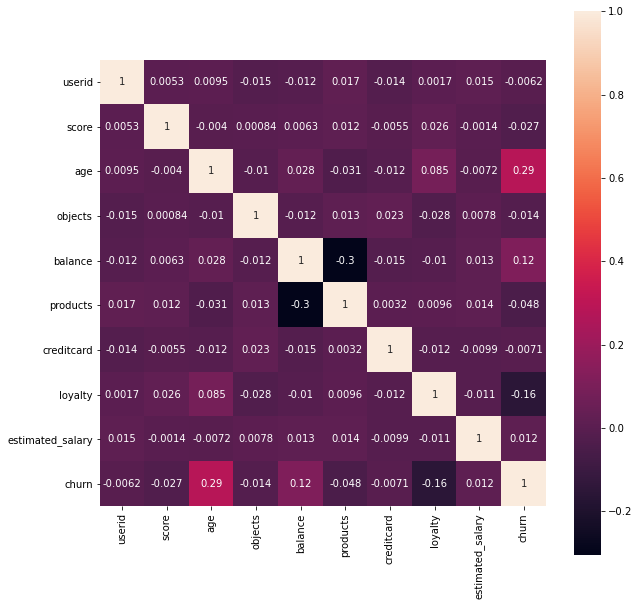

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True, square=True)
plt.show()

1. Первое, что бросается в глаза - максимальная корреляция по модулю не больше 0.3. Т.е. говорить о сильной линейной взаимосвязи факторов не приходится вообще.
2. Небольшую отрицательную взаимосвязь имеет пара "Количество продуктов" и "Баланс", т.е. чем выше баланс тем меньше продуктов, и наоборот, чем меньше продуктов, тем выше баланс. Можно было бы предположить, что доп продукты банка отпугивают клиентов, но пока данных для такого вывода не достаточно.
3. Небольшая положительная взаимосвязь у пары "Возраст" и "Отток". Т.е. старшие поколения немного более склонны отказываться от продуктов банка, что может быть обусловлено и естественными причинами. Например, более высокой смертностью у старших поколений от естественных причин.

Для некатегориальных факторов попробуем выявить нелинейные взаимосвязи на графиках точечного распределения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0F6174D8>,
      dtype=object)

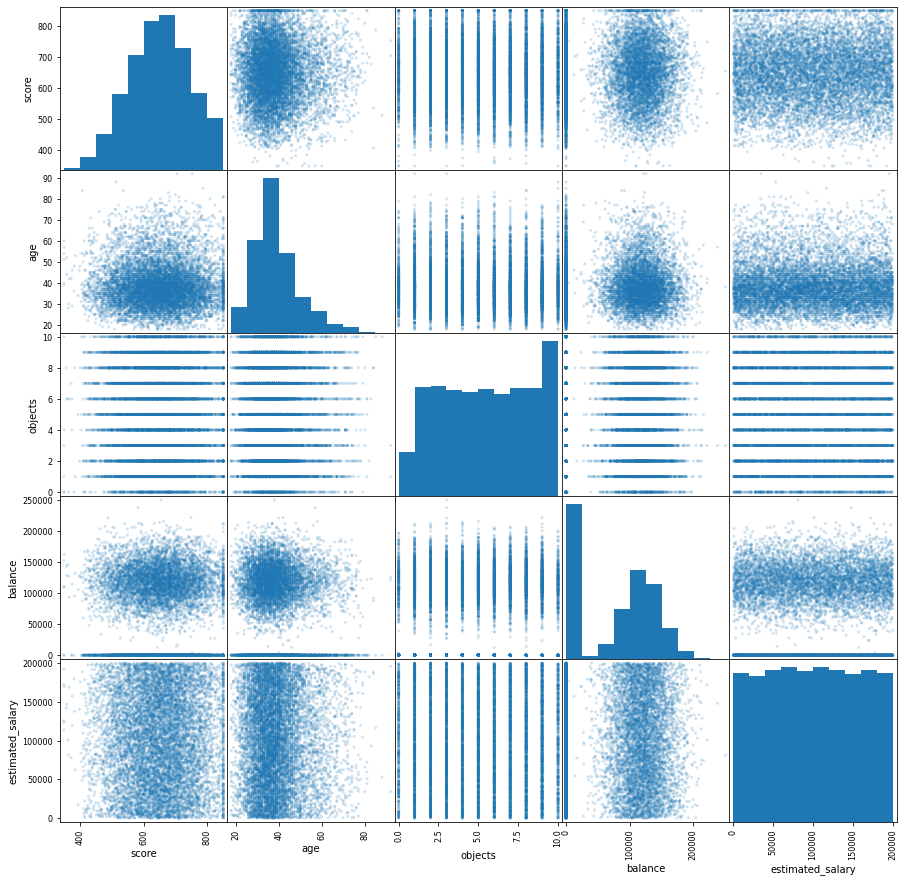

In [20]:
pd.plotting.scatter_matrix(df[numeric_columns], figsize=(15,15), alpha=0.2)

Хотя такой способ отражения данных не позволяет разглядывать подробности, он достаточно наглядно демонстрирует отсутствие нелинейно искривленных распределений. Для нас это означает, что между факторами нет не только сильной линейной корреляции, но и явной нелинейной взаимосвязи.

## 3. Сегментация клиентов <a id=3></a>

#### 3.1 Группировка клиентов по количеству продуктов <a id=3.1></a>

Как мы уже знаем, количество клиентов с 3-мя и 4-мя продуктами очень малочисленно. Для повышения репрезентативности выборки, объединим эти категории в одну. Для этого создадим отдельную колонку `products_owner_category`. Колонка будет заполняться целыми числами от 1 до 3 и обозначать три сегмента клиентов:
- 1 сегмент - владельцы одного продукта
- 2 сегмент - владельцы двух продуктов
- 3 сегмент - владельцы 3-х и более продуктов

In [21]:
#создаем колонку как копию products
df['products_owner_category'] = df['products']
# заменяем 4 на 3
df['products_owner_category'] = df['products_owner_category'].replace(4,3)

# Проверим распределение значений
df['products_owner_category'].value_counts()


1    5084
2    4590
3     326
Name: products_owner_category, dtype: int64

Теперь можно с немного большей статистической уверенностью судить о предпочтениях объединенного сегмента.

In [22]:
# разделим изначальную таблицу на три отдельных для каждого сегмента
df_1 = df.query('products_owner_category == 1')
df_2 = df.query('products_owner_category == 2')
df_3 = df.query('products_owner_category == 3')

#### 3.2 Выявление характерных особенностей групп <a id=3.2></a>

Для выявления характерных особенностей групп сравним, как распределены признаки в сегментах. При этом количественные признаки будем сравнивать при помощи boxplot, а категориальные снова кольцевыми диаграммами.

In [23]:
# напишем функцию для построения графиков go.Box
def boxplot (column,title,y_title):
    fig = go.Figure()
    fig.add_trace(go.Box(y=df_1[column], name='1 сегмент'))
    fig.add_trace(go.Box(y=df_2[column], name='2 сегмент'))
    fig.add_trace(go.Box(y=df_3[column], name='3 сегмент'))
    fig.update_layout(title=title,
                  xaxis_title="Сегмент",
                  yaxis_title=y_title)
    fig.show()

Сравним сегменты по кредитному рейтингу.

In [24]:
boxplot('score',"Сравнение кредитного рейтинга в сегментах","Кредитный рейтинг")

Ни один из сегментов не выделяется особенностями кредитного рейтинга.

Поищем различия в возрасте.

In [25]:
boxplot('age',"Сравнение возраста в сегментах","Возраст")

Можно сказать, что третий сегмент немного старше. Посмотрим каково отличие третьего сегмента в среднем.

In [26]:
print(
    'Средний возраст в 1 и 2 сегментах: {:.0f}'.format(
    df.query('products == 1 or products == 2')['age'].mean()))
print(
    'Средний возраст в 3 сегменте: {:.0f}'.format(
df.query('products == 3 or products == 4')['age'].mean()))

Средний возраст в 1 и 2 сегментах: 39
Средний возраст в 3 сегменте: 44


Можно сказать, что третий сегмент в среднем старше примерно на 5 лет.

Есть ли различия в количестве объектов собственности?

In [27]:
boxplot('objects',"Сравнение количества объектов собственности в сегментах","Количество объектов собственности")

Хотя различий в медианных значениях нет, 1 сегмент чуть больше скошен в сторону небольшого количества объектов, а 3 сегмент скошен в пользу бОльшего количества объектов. Это значит, что у некоторых клиентов в третьем сегменте больший потенциал например, в продуктах страхования собственнности.

Есть ли различия в остатках по счетам?

In [28]:
boxplot('balance',"Сравнение остатков на счетах в сегментах","Остаток средств в банке")

График остатков по счетам демонстрирует существенные различия в сегментах. Исследуем эти различия подробнее. Построим распределение остатков на счетах, но не в абсолютных значениях(группы слишком разные по численности), а в процентах от общего количества.

In [29]:

fig = go.Figure()
fig.add_trace(go.Histogram(x = df_1['balance'], name='1 сегмент',histnorm='percent'))                 
fig.add_trace(go.Histogram(x = df_2['balance'], name='2 сегмент',histnorm='percent'))
fig.add_trace(go.Histogram(x = df_3['balance'], name='3 сегмент',histnorm='percent'))
    
fig.update_layout(xaxis = {'title': 'Баланс'},
        yaxis = {'title': 'Количество клиентов'},
        bargap = 0.05)          
fig.show()

График не очень красив, но информативен. Мы видим, что сегменты прежде всего различаются по доле нулевых остатков, т.е. клиентов не имеющих счета в нашем банке. В первом сегменте таких всего около 18 %, во втором почти 57%, а третий находится в середине - около 34%. Попробуем отделить данные о нулевых остатках, и выяснить, есть ли различия в распределении остатков, по клиентам у которых есть счета.

In [30]:
fig = go.Figure()
fig.add_trace(go.Box(y=df_1.query('balance > 0')['balance'], name='1 сегмент'))
fig.add_trace(go.Box(y=df_2.query('balance > 0')['balance'], name='2 сегмент'))
fig.add_trace(go.Box(y=df_3.query('balance > 0')['balance'], name='3 сегмент'))
fig.update_layout(title="Сравнение остатков на счетах в сегментах <br>(за исключением нулевых)",
                  xaxis_title="Сегмент",
                  yaxis_title="Остаток средств в банке")
fig.show()

Различия в распределении остатков, у клиентов имеющих счет в банке не существенны. Делаем вывод о том, что фактором различия сегментов является не распределение остатков, а доля клиентов, у которых нет счета в нашем банке. Стоит проверить статистическую значимость этого различия, чтобы убедиться в нем. Сделаем это на этапе проверки статистических гипотез.

Следующий числовой параметр - оценочная заработная плата. Сравним характеристики распределений.

In [31]:
boxplot('estimated_salary',"Сравнение оценочной заработной платы в сегментах","Оценочная з/п")

Третий сегмент немного богаче, но различия не существенны. 

Теперь посмотрим, есть ли отличия в распределении категориальных признаков. 

In [32]:
# создаем фуфнкцию построения графиков
def pie(column, title):
    fig = make_subplots(rows=1, cols=3, 
                specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                
                subplot_titles=['Сегмент 1','Сегмент 2','Сегмент 3'])


    fig.add_trace(go.Pie(labels= df_1[column].value_counts().index, values = np.array(
        df_1[column].value_counts()), hole=0.7), row=1, col=1)

    fig.add_trace(go.Pie(labels= df_2[column].value_counts().index , values = np.array(
        df_2[column].value_counts()),hole=0.7), row=1, col=2)

    fig.add_trace(go.Pie(labels= df_3[column].value_counts().index ,values = np.array(
        df_3[column].value_counts()), hole=0.7), row=1, col=3)

    fig.update_layout(title=title)
    fig.show()

Начнем с распределения по городам.

In [33]:
pie('city',"Распределение клиентов в сегментах по городам")

Распределение в сегментах 1 и 2 почти идентично. В 3-ем сегменте больше доля клиентов из Ростова Великого, и немного меньше из Ярославля. Зная, что третий сегмент более насыщен продуктами банка, можно предположить, что успехи по продажам в Ростове несколько лучше. 

Различается ли гендерная составляющая?

In [34]:
pie('gender',"Распределение клиентов в сегментах по гендерному признаку")

На этот раз третий сегмент выделяется бОльшей долей женщин, но различие не велико.

Посмотрим, засисит ли от сегмента доля клиентов с кредитной картой?

In [35]:
pie('creditcard',"Распределение клиентов в сегментах по наличию кредитной карты")

По кредиткам сегменты идентичны. 

Посмотрим есть ли различия в активности.

In [36]:
pie('loyalty',"Распределение клиентов в сегментах по признаку активности")

По активности клиентов сегменты почти идентичны. Трнтий чуть менее активен.

Рассмотрим различия в оттоке?

In [37]:
pie('churn', "Распределение клиентов в сегментах по признаку оттока")

 Самый надежный - сегмент №2. Клиенты из третьего сегмента почти гарантированно попадают в отток. Это одно из самых радикальных отличий в сегментах.

Перечислим признаки, по которым между всеми или некоторыми сегментами есть заметная разница
1. Возраст - выделяется 3-й сегмент
2. Доля клиентов без счета в банке - все сегменты различны
3. Город - выделяется третий сегмент
4. Отток - наибольшее различие между сегментами


Соберем в одно описание отличительные особенности каждого сегмента по различающимся признакам.


Сегмент 1:
- 1 продукт банка
- Самая низкая доля клиентов без счета в нашем банке(18%)
- Средняя надежность(27% оттока)

Сегмент 2:
- 2 продукта банка
- Самая высокая доля клиентов без счетов в банке (57%)
- Минимальный уровень оттока (меньше 8%)

Сегмент 3:
- 3 и более продкутов банка
- Немного старше 1-го и 2-го сегментов.
- Средний по доле клиентов без счета (34%).
- Больше доля клиентов из Ростова(в основном, в ущерб Ярославлю), чем в сегментах 1 и 2.
- 86% оттока

Для разбора вне рамок данного проекта можно сформулировать следующие наблюдения и предположения:

- По какой-то причине, если вы обладаете 3-мя и более продуктами банка, то почти гарантированно попадете в отток. При этом вы с немного большей вероятностью живете в Ростове, и старше, чем представители других сегментов.

- Важно помнить также, что группа владельцев 3-х и более продуктов значительно малочисленнее. Это может быть обусловлено тем, что два из четырех продуктов банка не востребованы, или тем, что продукты новые, и еще не набрали свою аудиторию. С учетом катастрофического показателя оттока вероятно предположить также, что какие-то продукты банка отпугивают клиентов, что и делает их обладателей малочисленной группой.

- Фактор наличия счета в банке скорее является негативным с точки зрения оттока т.к. у первого и третьего сегмента меньше доля клиентов без счета и выше отток, но отсутствие линейной корреляции говорит о том, что вмешиваются и другие, существенные факторы.

- Возможно, картину могли бы прояснить дополнительные данные о том, какими именно продуктами владеют те или иные клиенты, и построение портрета клиента не только с точки зрения количества продуктов, но и с точки зрения их состава.

## 4. Проверка статистических гипотез <a id=4></a>

#### 4.1 Проверка статистической гипотезы клиента : «различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним». <a id=4.1></a>

Построенные ранее графики boxplot не продемонстрировали существенной разницы в уровне дохода между 1-м и 2-м сегментом ни в медиане ни в разбросе. Однако, по просьбе клиента проведем дополнительно проверку статистической гипотезы.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза. Средний уровень `estimated_salary` у клиентов владеющих одним продуктом и клиентов владеющих двумя продуктами рывны.
- Альтернативная гипотеза. Средний уровень `estimated_salary` у клиентов владеющих одним продуктом и клиентов владеющих двумя продуктами различаются.

Выбор метода проверки статистической гипотезы зависит от того, имеют ли данные нормальное распределение? Проверим это методом Шапиро-Уилка. Для проверки в свою очерель необходимо сформулировать гипотезы о нормальности распределения. Сделаем это.

- Нулевая гипотеза. Распределение данных в выборке `estimated_salary` является нормальным.

- Альтернативная гипотеза. Распределение данных в выборке `estimated_salary` не является нормальным.

Т.к. нас прежде всего интересуют данные по владельцам 1-го и 2-х продуктов, то и данные `estimated_salary` возьмем только по ним.

In [38]:
from scipy import stats as st

# отбираем нужные данные для проверки нормальности распределения
sample_1 = (df.query('products < 3')['estimated_salary']).tolist()

alpha = .05 # классический порог статистической значимости, т.к. это не вопрос жизни и смерти

results = st.shapiro(sample_1)# результаты применения метода Шапиро-Уилка из модуля stats библиотеки scipy
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



Т.к. распределение данных не нормальное, то для проверки основной гипотезы необходимо применять непараметрические статистические критерии. Применим непараметрический критерий Манна_Уитни.



Т.к. нас интересует отклонение в любую сторону, то алгоритм проверки выбираем двусторонний.

In [39]:
products_1= (df.query('products == 1')['estimated_salary']).tolist()
products_2 = (df.query('products == 2')['estimated_salary']).tolist()

alpha = .05 # классический порог статистической значимости, т.к. это не вопрос жизни и смерти

results = st.mannwhitneyu(products_1, products_2)# результаты теста Манна_Уитни из модуля stats библиотеки scipy

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

p-значение:  0.20398143033158866
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Нулевую гипотезу отвергнуть не удалось. Мы не можем утверждать, что средний уровень estimated_salary у клиентов владеющих одним продуктом и клиентов владеющих двумя продуктами различаются.

#### 4.2 формулировка и проверка собственной статистической гипотезы на основе проведенного исследовательского анализа <a id=4.2></a>

Одно из выявленных различий между сегментами - разница долей клиентов не имеющих счета в нашем банке. Проверим подтверждается ли эта разница статистическим критерием. Т.к. речь идет не о количественном распределении, а о разнице долей, то проверять будем z критерием. 

Т.к. самой малочисленной и, следовательно, нуждающейся в проверке по статистической значимости, является группа третьего сегмента, то сравним ее, например, с группой второго сегмента.

Итак, сформулируем гипотезы.

Нулевая гипотеза. Доля клиентов с нулевым остатком в нашем банке одинакова у клиентов с двуя и с тремя и более продуктами.

Альтернативная, наиболее интересная для нас гипотеза.  Доля клиентов с нулевым остатком в нашем банке различается у клиентов с двуя и с тремя и более продуктами.

In [40]:

import math as mth

# Посчитаем, размеры выборок, как количество клиентов по сегментам
total = np.array([df_2['userid'].count(),df_3['userid'].count()])

#Посчитаем количество клиентов у которых нулевые остатки по сегментам
part = np.array([df_2[df_2['balance'] == 0]['userid'].count(),df_3[df_3['balance'] == 0]['userid'].count()])

alpha = .05 # классический уровень статистической значимости


# пропорция 'нулевиков' в первой группе:
p1 = part[0]/total[0]

# пропорция 'нулевиков' во второй группе:
p2 = part[1]/total[1]

# пропорция 'нулевиков' в комбинированном датасете:
p_combined = (part[0] + part[1]) / (total[0] + total[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 


p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  5.329070518200751e-15
Отвергаем нулевую гипотезу: между долями есть значимая разница


Обнаруженная нами разница в долях клиентов не имеющих своего счета получила свое статистическое подтверждение, как минимум для 2 и 3 сегмента.

## 5 Выводы <a id=5></a>

1. В связи с малым количеством данных для владельцев 3-х и 4-х продуктов для увеличения статистической значимости выводов целесообразно рассматривать их как один сегмент.

2. Критерии, по которым удалось обнаружить заметные различия между сегментами:
 - Возраст - выделяется 3-й сегмент
 - Доля клиентов без счета в банке - все сегменты различны
 - Город - выделяется третий сегмент
 - Отток - наибольшее различие между всеми сегментами



3. С учетом наиболее ярких различий портрет клиентов в сегментах выглядит следующим образом
 
    
Сегмент 1:
- 1 продукт банка
- Самая низкая доля клиентов без счета в нашем банке(18%)
- Средняя надежность(27% оттока)


Сегмент 2:
- 2 продукта банка
- Самая высокая доля клиентов без счетов в банке (57%)
- Минимальный уровень оттока (меньше 8%)


Сегмент 3:
- 3 и более продкутов банка
- Немного старше 1-го и 2-го сегментов.
- Средний по доле клиентов без счета (34%).
- Больше доля клиентов из Ростова(в основном, в ущерб Ярославлю), чем в сегментах 1 и 2.
- 86% оттока

4. Гипотеза клиента о разнице в уровне доходов между клиентами с 1-им и 2-мя продуктами не подтвердилась.

5. Гипотеза выработанная в рамках проекта о разнице в доле клиентов не имеющих счета получила статистическое подтверждение как минимум, для 2 и 3 сегмента.

6. Т.к. разница в долях оттока между сегментами еще больше, чем разница в долях клиентов с нулевым остатком. Кажется очевидным, что гипотеза о разнице в уровне оттока в проверке не нуждается, как минимум между 3-им и остальными сегментами.

7. Фактор наличия счета в банке скорее является негативным с точки зрения оттока т.к. у первого и третьего сегмента меньше доля клиентов без счета и выше отток, но отсутствие линейной корреляции говорит о том, что вмешиваются и другие, существенные факторы.

8. Возможно, картину могли бы прояснить дополнительные данные о том, какими именно продуктами владеют те или иные клиенты, и построение портрета клиента не только с точки зрения количества продуктов, но и с точки зрения их состава.